In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("csvs/titanicdata.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
df.drop(columns=["Name", "Cabin"], inplace=True)
df.dropna(inplace=True)
#droppin the name column because its insignificant and the cabin column because it has insufficient data
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,female,35.0,1,0,113803,53.1000,S
4,5,0,3,male,35.0,0,0,373450,8.0500,S


In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for column in ["Sex", "Ticket", "Embarked"]:
    df[column] = le.fit_transform(df[column])

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Sex          712 non-null    int64  
 4   Age          712 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    int64  
 8   Fare         712 non-null    float64
 9   Embarked     712 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 61.2 KB


## Training the same model with different scaled data


In [102]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split 
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

scalers = [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
accuracies = {}

X = df.drop(columns=["Survived"])
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

clf = LinearSVC()

for scaler in scalers:
    X_train_scaled = scaler.fit_transform(X_train) if scaler is not None else X_train
    X_test_scaled = scaler.fit_transform(X_test) if scaler is not None else X_test

    clf.fit(X_train_scaled, y_train)
    pred = clf.predict(X_test_scaled)

    col = scaler.__class__.__name__ if scaler is not None else "Initial"
    accuracies[col] = [accuracy_score(y_test, pred)]
accuracies

{'Initial': [0.7762237762237763],
 'StandardScaler': [0.7692307692307693],
 'MinMaxScaler': [0.7622377622377622],
 'MaxAbsScaler': [0.7622377622377622]}

We can see that in this case the accuracies are very comparable, the initial not scaled data having slightly the highest accuracy

In [55]:
results = pd.DataFrame(data = accuracies)
results

,Initial,StandardScaler,MinMaxScaler,MaxAbsScaler
0,0.776224,0.769231,0.762238,0.762238


### Correlation 

In [56]:
df.corr().style.background_gradient(cmap="coolwarm")

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,1.000000,0.029526,-0.035609,0.024674,0.033681,-0.082704,-0.011672,-0.050703,0.009655,-0.001836
Survived,0.029526,1.000000,-0.356462,-0.536762,-0.082446,-0.015523,0.095265,-0.147669,0.266100,-0.181979
Pclass,-0.035609,-0.356462,1.000000,0.150826,-0.365902,0.065187,0.023666,0.324430,-0.552893,0.244145
Sex,0.024674,-0.536762,0.150826,1.000000,0.099037,-0.106296,-0.249543,0.067311,-0.182457,0.109639
Age,0.033681,-0.082446,-0.365902,0.099037,1.000000,-0.307351,-0.187896,-0.076199,0.093143,-0.032565
SibSp,-0.082704,-0.015523,0.065187,-0.106296,-0.307351,1.000000,0.383338,0.002448,0.139860,0.033064
Parch,-0.011672,0.095265,0.023666,-0.249543,-0.187896,0.383338,1.000000,-0.001817,0.206624,0.011803
Ticket,-0.050703,-0.147669,0.324430,0.067311,-0.076199,0.002448,-0.001817,1.000000,-0.031926,-0.021201
Fare,0.009655,0.266100,-0.552893,-0.182457,0.093143,0.139860,0.206624,-0.031926,1.000000,-0.283510
Embarked,-0.001836,-0.181979,0.244145,0.109639,-0.032565,0.033064,0.011803,-0.021201,-0.283510,1.000000


In [58]:
df.corr()["Survived"].sort_values()

Sex           -0.536762
Pclass        -0.356462
Embarked      -0.181979
Ticket        -0.147669
Age           -0.082446
SibSp         -0.015523
PassengerId    0.029526
Parch          0.095265
Fare           0.266100
Survived       1.000000
Name: Survived, dtype: float64

## Decision Boundary

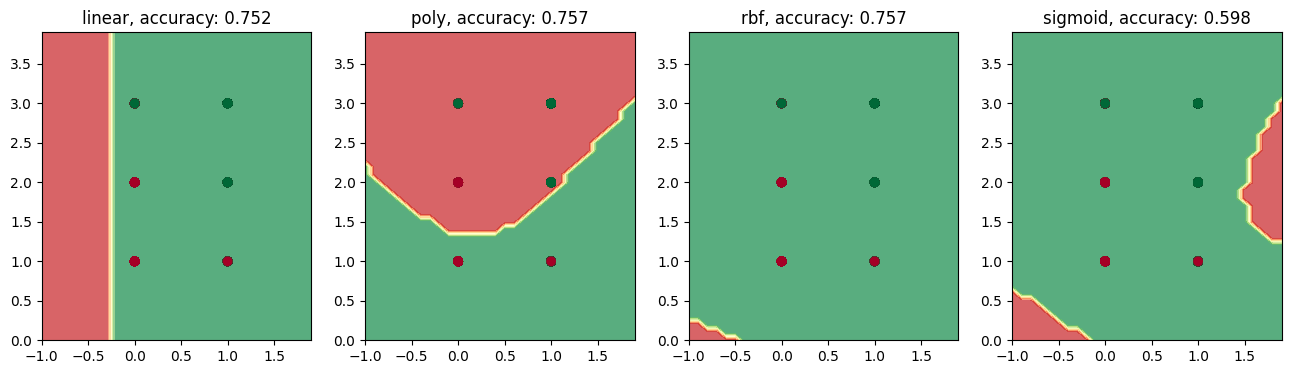

In [104]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X = np.array(df[["Sex", "Pclass"]])
y = np.array(df["Survived"])

scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

kernels = ["linear", "poly", "rbf", "sigmoid"]

# define bounds of the domain
min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1

# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)

# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)

# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

fig, axes = plt.subplots(1, 4, figsize = (16, 4)) 

for i, kernel in enumerate(kernels):
    clf = SVC(kernel=kernel, random_state=42)
    clf.fit(X_train_scaled, y_train)

    # make predictions for the grid
    yhat = clf.predict(grid)

    score = clf.score(X_test_scaled, y_test)
    score = round(score, 3)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)

    # plot the grid of x, y and z values as a surface
    axes[i].contourf(xx, yy, zz, cmap="RdYlGn_r", alpha = 0.7)
    axes[i].scatter(X[:, 0], X[:, 1], cmap="RdYlGn_r", c=y)
    axes[i].set_title(f"{kernel}, accuracy: {score}")

We can see that the accuracy of the sigmoid kernel is the smallest, while the accucary of the linear, poly and rbj kernels are similar

## Confusion matrix for each kernel

linear kernel


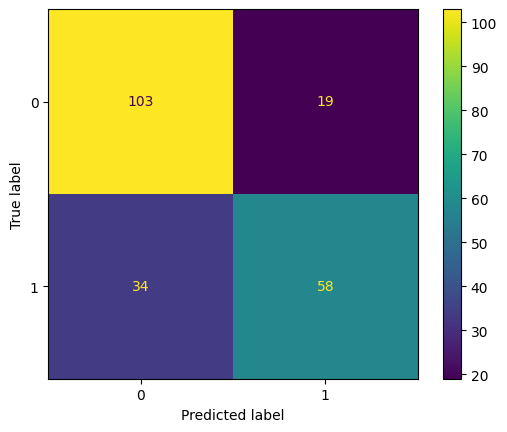

poly kernel


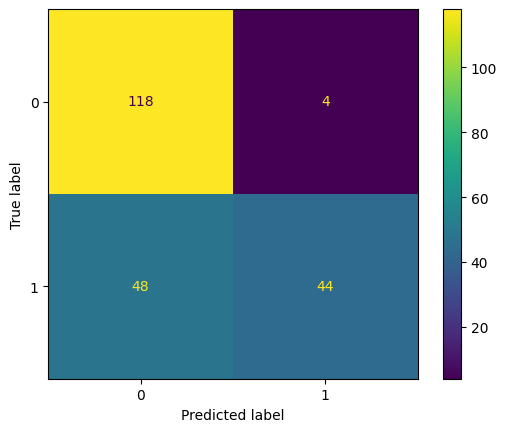

rbf kernel


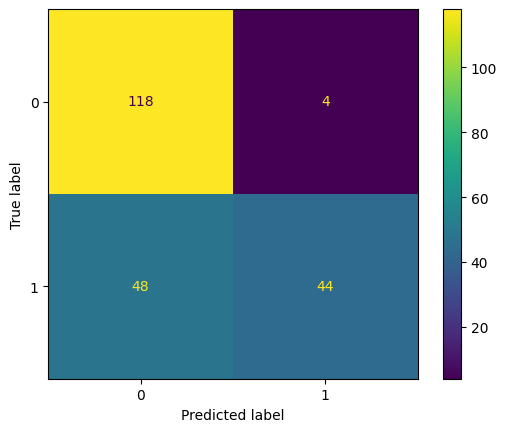

sigmoid kernel


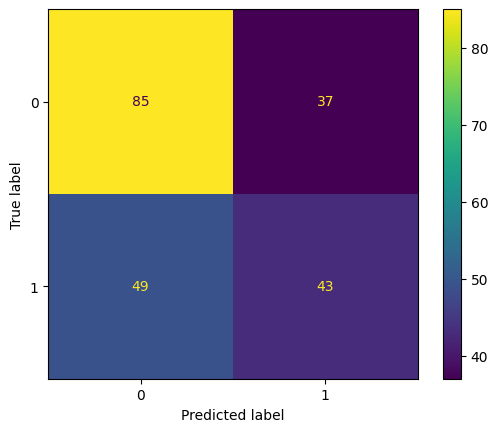

In [109]:
from sklearn.metrics import ConfusionMatrixDisplay


for kernel in kernels:
    clf = SVC(kernel=kernel, random_state=42)
    clf.fit(X_train_scaled, y_train)
    print(f"{kernel} kernel")
    ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test)
    plt.show()

## Conclusion
Choosing a kernel is an important part of training a SVM model, because it can affect the end results, and what kernel you choose depends on the data given and the circumstances. The top three kernels were linear, rbf and poly, but I belive their performance could very given differect data